## Assignment 1: Model creation
**Course:** Security and Interpretability of Machine Learning algorithms <br>
**Student:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 

#### Backlog:

1. <s> Add augmentations (albumentations)</s>
2. Try torch lightning
3. Multi-label classification.
4. Optuna?
5. <s> Regularization </s>
6. Cross-validation
7. <s> Add testing in train routine </s>
8. <s> Draw train error </s>


### 0. Prerequisites.

In [1]:
import torch 
import torchvision
import os
import pickle
import matplotlib
import albumentations as A
import random
import numpy as np

In [2]:
from albumentations import pytorch
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score

In [3]:
configs = {
    "num_workers": 4,
    "device": "cuda:0",
    "batch_size": 128,
    "epochs": 50
}

In [4]:
import warnings
warnings.filterwarnings("ignore")

### 1. Loading Data.

The CIFAR-10 dataset was downloaded from [official publisher](https://www.cs.toronto.edu/~kriz/cifar.html) and mounted to `data/cifar/` directory. Further, the loading of data will be performed through Dataset abstraction. Native implementation does not support transforms via Albumentations package, so I create a custom class for this purpose.

In [5]:
class AlbumentationsCIFAR10(CIFAR10):
    """
    Custom CIFAR10 dataset applying transformations according to
    Albumentations standard. Inherited from native PyTorch dataset
    implementing the retrival logic.
    """
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]
        if self.transform is None:
            return image, label
        try:
            transformed = self.transform(image=image)['image']
        except Exception as e:
            print(e)
            transformed = self.transform(image)
        return transformed, label
            

In [6]:
train_augmentations = A.Compose([
    A.augmentations.transforms.Normalize(),
    A.HorizontalFlip(p=0.5),
    A.augmentations.geometric.transforms.ShiftScaleRotate(p=0.5),
    A.augmentations.geometric.transforms.ElasticTransform(p=0.1),
    pytorch.transforms.ToTensorV2(),
])

test_augmentations = A.Compose([
    A.augmentations.transforms.Normalize(),
    pytorch.transforms.ToTensorV2(),
])

Further in the notebook, there will be used validation, train, and test datasets. The validation set will be used to tune hyper-parameters of the model via Optuna, and check the overall performance of the resultant model. The train and test sets will be used for training the model.

In [7]:
trainset = AlbumentationsCIFAR10(root='data', train=True, download=True, transform=train_augmentations)
trainloader = DataLoader(trainset, batch_size=configs['batch_size'], shuffle=True, num_workers=configs['num_workers'])

Files already downloaded and verified


In [8]:
split_ration = 0.5

controlset = AlbumentationsCIFAR10(root='data', train=False, download=True, transform=test_augmentations)
test_size = int(split_ration * len(controlset))
validation_size = len(controlset) - test_size
testset, validationset = torch.utils.data.random_split(controlset, [test_size, validation_size])
testloader = DataLoader(testset, batch_size=configs['batch_size'], shuffle=False, num_workers=configs['num_workers'])
validationloader = DataLoader(validationset, batch_size=configs['batch_size'], shuffle=False, num_workers=configs['num_workers'])

Files already downloaded and verified


In [9]:
print(f"Datasets' sizes: train {len(trainset)}, test: {len(testset)}, validation: {len(validationset)}")

Datasets' sizes: train 50000, test: 5000, validation: 5000


Let's examine five random samples from training population.

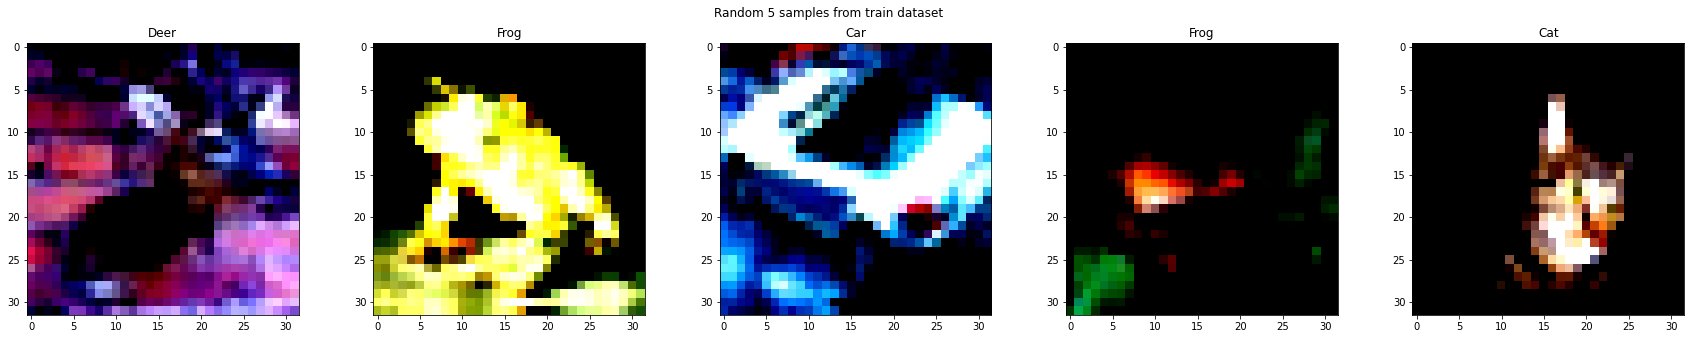

In [10]:
classes = {
    0: 'Airplane',
    1: 'Car',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

fig, axes = plt.subplots(1, 5)
fig.set_size_inches(30, 5)
fig.suptitle("Random 5 samples from train dataset")
for ax in axes:
    idx = random.randint(0, len(trainset)-1)
    image, label = trainset[idx]
    ax.set_title(f"{classes[label]}")
    image = np.clip(image.permute(1, 2, 0), 0, 1)
    ax.imshow(image)
plt.show()

### 2. Building a Model.

Multi-label classification of objects in images is known problem. Various state-of-art model were developed. For instance, the Residual Network (ResNet) significantly improved the performance of deep neural networks. The overall idea and architecture are presented in ["Deep Residual Learning for Image Recognition"](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming H. et al. For this assignment I will implement the variation of ResNet with 18 layers.

In [11]:
class ResidualBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.identity = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.identity = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)                
            )
    
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.identity(x)
        out = F.relu(out)
        return out 

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [17]:
def train(model, criterion, loader, optimizer):
    model.to(configs['device'])
    model.train()
    
    train_loss = 0.0
    accuracy = []
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(configs['device']), labels.to(configs['device'])
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted_classes = predictions.max(1)
        predicted_classes = predicted_classes.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        accuracy.append(balanced_accuracy_score(labels, predicted_classes))
        
    return train_loss / len(loader), np.mean(np.array(accuracy))
        

def test(model, criterion, loader):
    model.eval()
    test_loss = 0.0
    accuracy = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(configs['device']), labels.to(configs['device'])
            predictions = model(images)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            _, predicted_classes = predictions.max(1)
            predicted_classes = predicted_classes.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            accuracy.append(balanced_accuracy_score(labels, predicted_classes))
    
    return test_loss / len(loader), np.mean(np.array(accuracy))
    

### 3. Tuning Hyperparameters.

### 4. Training the model.

In [14]:
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(configs['device'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [15]:
losses = {'train': [], 'test': []}
accuracies = {'train': [], 'test': []}

for epoch in range(configs['epochs']):  
    train_loss, train_accuracy = train(model, criterion, trainloader, optimizer)
    test_loss, test_accuracy = test(model, criterion, testloader)
    scheduler.step()
    
    losses['train'].append(train_loss)
    losses['test'].append(test_loss)
    accuracies['train'].append(train_accuracy)
    accuracies['test'].append(test_accuracy)
    print(f"Epoch: {epoch+1:02d} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train accuracy: {train_accuracy:.5f} | Test accuracy: {test_accuracy:.5f}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss, 
    }, os.path.join("weights", f"{epoch}.pt"))

Epoch: 01 | Train loss: 1.71046 | Test loss: 1.45332 | Train accuracy: 0.38076 | Test accuracy: 0.47977
Epoch: 02 | Train loss: 1.40449 | Test loss: 1.27484 | Train accuracy: 0.50494 | Test accuracy: 0.55493
Epoch: 03 | Train loss: 1.24233 | Test loss: 1.07381 | Train accuracy: 0.56726 | Test accuracy: 0.61619
Epoch: 04 | Train loss: 1.13234 | Test loss: 0.93656 | Train accuracy: 0.60379 | Test accuracy: 0.66281
Epoch: 05 | Train loss: 1.05158 | Test loss: 0.90316 | Train accuracy: 0.63141 | Test accuracy: 0.67762
Epoch: 06 | Train loss: 0.97405 | Test loss: 0.81693 | Train accuracy: 0.65907 | Test accuracy: 0.71937
Epoch: 07 | Train loss: 0.91089 | Test loss: 0.78463 | Train accuracy: 0.68356 | Test accuracy: 0.72829
Epoch: 08 | Train loss: 0.85784 | Test loss: 0.67607 | Train accuracy: 0.70200 | Test accuracy: 0.76242
Epoch: 09 | Train loss: 0.81854 | Test loss: 0.65607 | Train accuracy: 0.71601 | Test accuracy: 0.77317
Epoch: 10 | Train loss: 0.78093 | Test loss: 0.61513 | Train acc

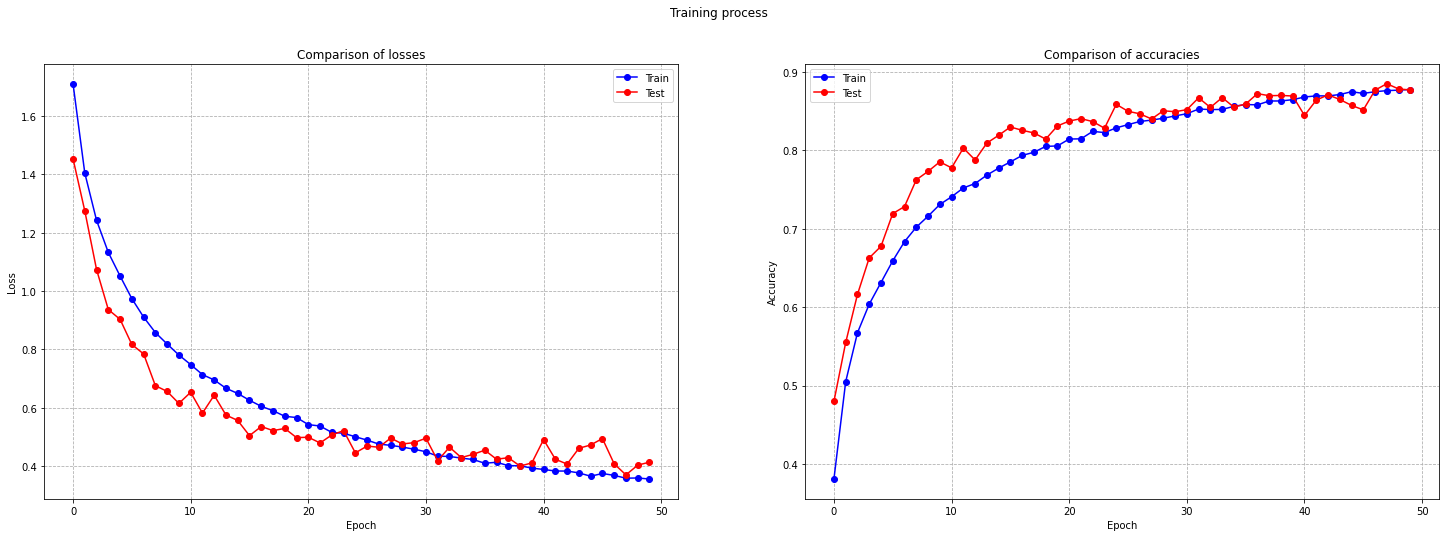

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(25, 8)
fig.suptitle(f"Training process")
ax1.set_title(f"Comparison of losses")
ax1.grid(linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(np.arange(len(losses['train'])), np.array(losses['train']), '-o', label='Train', c='b')
ax1.plot(np.arange(len(losses['test'])), np.array(losses['test']), '-o', label='Test', c='r')
ax1.legend()

ax2.set_title(f"Comparison of accuracies")
ax2.grid(linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.plot(np.arange(len(accuracies['train'])), np.array(accuracies['train']), '-o', label='Train', c='b')
ax2.plot(np.arange(len(accuracies['test'])), np.array(accuracies['test']), '-o', label='Test', c='r')
ax2.legend()

plt.show() 

### 5. Model Validation.

In [27]:
checkpoint = torch.load(os.path.join("weights", "47.pt"))
inferenced = ResNet(ResidualBlock, [2, 2, 2, 2]).to(configs['device'])
inferenced.load_state_dict(checkpoint['model_state_dict'])
inferenced.eval()

loss, accuracy = test(inferenced, criterion, validationloader)

In [28]:
print(f"The model has reached {accuracy * 100:.2f}% of weighted accuracy.")

The model has reached 87.23% of weighted accuracy.
